We noticed the CIL was very different between PSY4 and GLORYS12 on July 7, 2019. What might expain this differece? 

Let's look at the currents and sea surface height

In [1]:
import datetime
import glob
import os

import geopy.distance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
# Settings for this transect
TRANSECT='SealIsland'
STATIONS = pd.read_table('../data/csv/transects/{}/{}.txt'.format(TRANSECT, TRANSECT.lower()), 
                         delimiter=' ')

glorys_path='/data/cmems/my.cmems-du.eu/GLOBAL_MULTIYEAR_PHY_001_030/cmems_mod_glo_phy_my_0.083_P1D-m/'
psy4_path='/data/cmems/nrt.cmems-du.eu/GLOBAL_ANALYSIS_FORECAST_PHY_001_024/global-analysis-forecast-phy-001-024/'

In [3]:
lon_min=-65
lat_min=45
lon_max=-45
lat_max=60

In [4]:
# etopo file
ef = '/home/soontiensn/data/ocn-nav/ETOPO1_Bed_g_gmt4.grd'
etopo = xr.open_dataset(ef)
esel = etopo.sel(x=slice(lon_min, lon_max), y=slice(lat_min, lat_max))

In [5]:
def plot_bathymetry(ax, etopo):
    lons = etopo.x.values
    lats = etopo.y.values
    lons, lats = np.meshgrid(lons,lats)
    bathy = etopo.z.values
    levels = [-1000,-500, -200]
    CS = ax.contour(lons,lats,bathy,levels, linestyles='solid', linewidths=1,colors='k')
    #ax.clabel(CS, CS.levels, inline=True, fmt='%1.0f', fontsize=12)

In [6]:
date=datetime.datetime(2019,7,8)

In [7]:
glorys_file = glob.glob(os.path.join(glorys_path, date.strftime('%Y/%m/*%Y%m%d_*.nc')))
psy4_file = glob.glob(os.path.join(psy4_path, date.strftime('%Y/%m/*%Y%m%d_*.nc')))

In [8]:
d_glorys=xr.open_dataset(glorys_file[0]).sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min,lon_max))
d_psy4=xr.open_dataset(psy4_file[0]).sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min,lon_max))

In [9]:
def interp_to_stations(d, stations, variables=['thetao', 'uo', 'vo']):
    drop=[]
    keep=variables.copy()
    keep.extend(['longitude', 'time', 'latitude', 'depth'])
    for v in d.variables:
        if v not in keep:
            drop.append(v)
    print("Interpolating data to stations")
    dnew = pd.DataFrame()
    numrows=stations.shape[0]
    numdepths=d.depth.values.shape[0]
    for i in range(stations.shape[0]):
        print('Station {} of {}'.format(i, stations.shape[0]))
        lat=stations.iloc[i]['LAT']
        lon=stations.iloc[i]['LON']
        sid=stations.iloc[i]['STATION']
        dstation = d.interp(latitude=lat, longitude=lon)
        dstation = dstation.drop(drop)
        df=dstation.to_dataframe()
        df['station'] = sid
        df = df.reset_index()
        dnew = pd.concat([dnew,df])
    # Rename columns
    rename={var: '{} [{}]'.format(d[var].attrs['long_name'], d[var].attrs['units'])
        for var in dnew.columns if var not in ['station', 'time']}
    rename['station'] = 'STATION'
    rename['time'] = 'TIME'
    rename['longitude'] = 'LON'
    rename['latitude'] = 'LAT'
    dnew = dnew.rename(columns=rename)
    dnew = dnew.reset_index(drop=True)
    return dnew

In [10]:
def transect_arrays(d, stations, variable='Temperature [degrees_C]'):
    numstations=stations.shape[0]
    # distance along transect in km
    distance = [geopy.distance.distance((stations.iloc[0]['LAT'], stations.iloc[0]['LON']),
                                    (stations.iloc[i]['LAT'], stations.iloc[i]['LON'])).km for i in range(numstations)]
        # Create arrays
    var = d[variable].values
    depths = d['Depth [m]'].values
    size=len(var)
    # Reshape data
    numdepths = int(size/numstations)
    var = var.reshape((numstations, numdepths ))
    var = np.ma.masked_invalid(var)
    depths = depths.reshape((numstations, numdepths))
    _, distance = np.meshgrid(depths[0, :], distance)
    return distance, depths, var

In [11]:
def plot_transect(x,y,temp,speed,ax, vmin=0, vmax=.5):
    mesh=ax.contourf(x,y,speed,cmap='YlGnBu_r',levels=np.linspace(vmin, vmax))
    contour = ax.contour(x, y, temp, [0,], colors='k')
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('Speed [m/s]')
    ax.set_ylim([500,0])
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Distance [km]')
    ax.grid()

Interpolating data to stations
Station 0 of 14
Station 1 of 14
Station 2 of 14
Station 3 of 14
Station 4 of 14
Station 5 of 14
Station 6 of 14
Station 7 of 14
Station 8 of 14
Station 9 of 14
Station 10 of 14
Station 11 of 14
Station 12 of 14
Station 13 of 14
Interpolating data to stations
Station 0 of 14
Station 1 of 14
Station 2 of 14
Station 3 of 14
Station 4 of 14
Station 5 of 14
Station 6 of 14
Station 7 of 14
Station 8 of 14
Station 9 of 14
Station 10 of 14
Station 11 of 14
Station 12 of 14
Station 13 of 14


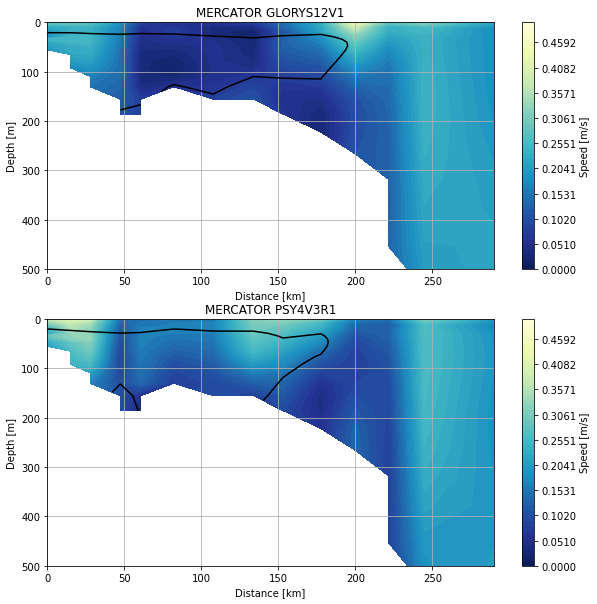

In [12]:
fig, axs = plt.subplots(2,1, figsize=(10,10))
for d, ax in zip( [d_glorys, d_psy4], axs):
    interp = interp_to_stations(d, STATIONS)
    interp['Speed [m/s]'] = np.sqrt(interp['Eastward velocity [m s-1]']**2 + 
                                    interp['Northward velocity [m s-1]']**2)
    distance, depths, temp = transect_arrays(interp, STATIONS,  variable='Temperature [degrees_C]')
    _, _, speed = transect_arrays(interp, STATIONS,  variable='Speed [m/s]')
    plot_transect(distance, depths, temp, speed, ax)
    ax.set_title(d.source)

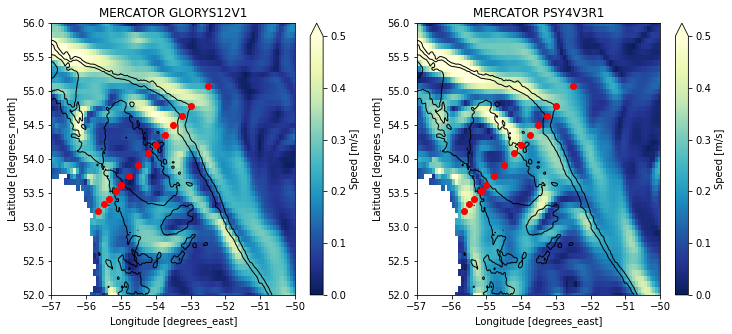

In [13]:

fig, axs = plt.subplots(1,2, figsize=(12,5))
for d, ax in zip( [d_glorys, d_psy4], axs):
    dsurf=d.isel(depth=0)
    surface_speed = np.sqrt(dsurf['uo']**2 +d.isel(depth=0)['vo']**2)
    surface_speed.attrs['units']='m/s'
    surface_speed.attrs['long_name']='Speed'
    surface_speed.plot(ax=ax, cmap='YlGnBu_r', vmin=0, vmax=0.5)
    ax.set_title(d.source)
    ax.plot(STATIONS['LON'].values, STATIONS['LAT'].values, 'ro',zorder=10)
    plot_bathymetry(ax,esel)
    ax.set_xlim([-57,-50])
    ax.set_ylim([52,56])

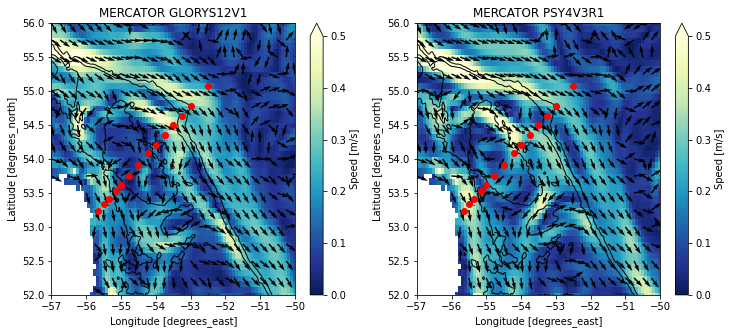

In [14]:
st=3
fig, axs = plt.subplots(1,2, figsize=(12,5))
for d, ax in zip( [d_glorys, d_psy4], axs):
    dsurf=d.isel(depth=0)
    surface_speed = np.sqrt(dsurf['uo']**2 +d.isel(depth=0)['vo']**2)
    surface_speed.attrs['units']='m/s'
    surface_speed.attrs['long_name']='Speed'
    surface_speed.plot(ax=ax, cmap='YlGnBu_r', vmin=0, vmax=0.5)
    q=ax.quiver(dsurf.longitude.values[::st],dsurf.latitude[::st],
                dsurf.uo.values[0,::st,::st]/surface_speed.values[0,::st,::st],
                dsurf.vo.values[0,::st,::st]/surface_speed.values[0,::st,::st],
                scale=20,
                color='k',
                width=0.006,
                zorder=2,
                edgecolors='k')
    #ax.quiverkey(q,0.1,0.2,0.2,'0.2 m/s',color='k',zorder=10)
    ax.set_title(d.source)
    ax.plot(STATIONS['LON'].values, STATIONS['LAT'].values, 'ro',zorder=10)
    plot_bathymetry(ax,esel)
    ax.set_xlim([-57,-50])
    ax.set_ylim([52,56])

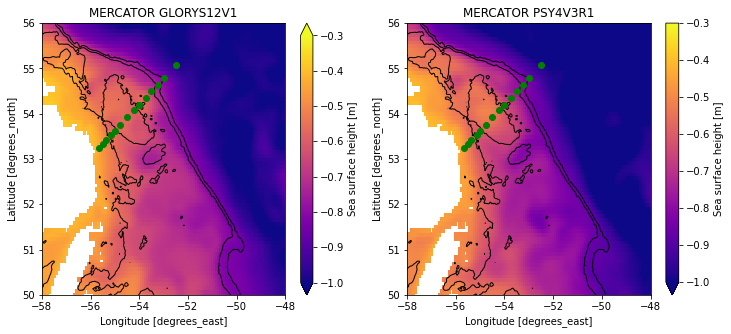

In [15]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
for d, ax in zip( [d_glorys, d_psy4], axs):
    d.zos.plot(ax=ax,vmin=-1,vmax=-.3, cmap='plasma')
    ax.set_title(d.source)
    ax.plot(STATIONS['LON'].values, STATIONS['LAT'].values, 'go')
    plot_bathymetry(ax,esel)
    ax.set_xlim([-58,-48])
    ax.set_ylim([50,56])

In [16]:
d_glorys

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 181, longitude: 241, time: 1)
Coordinates:
  * longitude  (longitude) float32 -65.0 -64.916664 ... -45.083332 -45.0
  * latitude   (latitude) float32 45.0 45.083332 45.166668 ... 59.916668 60.0
  * depth      (depth) float32 0.494025 1.541375 2.645669 ... 5274.784 5727.917
  * time       (time) datetime64[ns] 2019-07-08T12:00:00
Data variables:
    mlotst     (time, latitude, longitude) float32 ...
    zos        (time, latitude, longitude) float32 ...
    bottomT    (time, latitude, longitude) float32 ...
    sithick    (time, latitude, longitude) float32 ...
    siconc     (time, latitude, longitude) float32 ...
    usi        (time, latitude, longitude) float32 ...
    vsi        (time, latitude, longitude) float32 ...
    thetao     (time, depth, latitude, longitude) float32 ...
    so         (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    vo         (time, depth,

In [17]:
d_psy4

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 181, longitude: 241, time: 1)
Coordinates:
  * longitude  (longitude) float32 -65.0 -64.916664 ... -45.083332 -45.0
  * latitude   (latitude) float32 45.0 45.083332 45.166668 ... 59.916668 60.0
  * depth      (depth) float32 0.494025 1.541375 2.645669 ... 5274.784 5727.917
  * time       (time) datetime64[ns] 2019-07-08T12:00:00
Data variables:
    mlotst     (time, latitude, longitude) float32 ...
    zos        (time, latitude, longitude) float32 ...
    bottomT    (time, latitude, longitude) float32 ...
    sithick    (time, latitude, longitude) float32 ...
    siconc     (time, latitude, longitude) float32 ...
    usi        (time, latitude, longitude) float32 ...
    vsi        (time, latitude, longitude) float32 ...
    thetao     (time, depth, latitude, longitude) float32 ...
    so         (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    vo         (time, depth,